## Data Cleaning

In [1]:
%matplotlib inline
!pip install supersmoother

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", None)

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# define column names as defined by the NASA instructions

def load_cmapss_data(train_path, test_path, rul_path):

    # apply the unit number and the time (in cycles)
    index_names = ['unit_number', 'time_cycles']

    # there are three operational settings that are utilized by the engine
    setting_names = ['setting_1', 'setting_2', 'setting_3']

    # add sensor numbers to the sensors
    sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]

    # join the index, setting and sensor column names to then apply to the txt files
    col_names = index_names + setting_names + sensor_names

    # read txt data and apply the above
    train = pd.read_csv(train_path, sep='\s+', header=None, names=col_names)
    test = pd.read_csv(test_path, sep='\s+', header=None, names=col_names)
    y_test = pd.read_csv(rul_path, sep='\s+', header=None, names=['RUL'])

    return train, test, y_test

In [3]:
def load_cmapss_data(train_path, test_path, rul_path, include_sensor_desc = True):

    # sensor column descriptions
    description_headers = ["Temp, fan in", "Temp, LPC out", "Temp, HPC out", 
                           "Temp, LPT out", "Press, fan in", "Tot Press, bypass", "Tot Press, HPC out",
                           "Speed, fan", "Speed, core", "Eng Press Ratio", "Stat Press, HPC out", 
                           "phi Fuel Flow Ratio", "Corr. Speed, Fan", "Corr. Speed, Core", "Bypass Ratio", 
                           "Burner Fuel/Air Ratio", "Bleed Enthalpy", "Dem Speed, fan", "Dem Corr Speed, fan", 
                           "Coolant Bleed, HPT", "Coolant Bleed, LPT" ]
    
    # apply the unit number and the time (in cycles)
    index_names = ['unit_number', 'time_cycles']
    
    # there are three operational settings that are utilized by the engine 
    setting_names = ['setting_1', 'setting_2', 'setting_3']

    # add sensor numbers to the sensors
    sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
    
    # join the index, setting and sensor column names to then apply to the txt files
    if include_sensor_desc == False:
        col_names = index_names + setting_names + sensor_names
    else:
        col_names = index_names + setting_names + description_headers
    
    # read txt data and apply the above 
    train = pd.read_csv(train_path, sep='\s+', header=None, names=col_names)
    test = pd.read_csv(test_path, sep='\s+', header=None, names=col_names)
    y_test = pd.read_csv(rul_path, sep='\s+', header=None, names=['RUL'])
    
    return train, test, y_test

In [4]:
# Data Set: FD001
# Train trjectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: ONE (HPC Degradation)

# reading in the first dataset since it is a dataset that has one condition and one fault, and will allow us to make a relatively easier model
# that can then be built upon in complexity in the second stage of the analysis

train, test, y_test = load_cmapss_data('CMAPSSData/train_FD001.txt', 'CMAPSSData/test_FD001.txt', 'CMAPSSData/RUL_FD001.txt')

In [5]:
original_cols = train.columns
original_cols

Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       'Temp, fan in', 'Temp, LPC out', 'Temp, HPC out', 'Temp, LPT out',
       'Press, fan in', 'Tot Press, bypass', 'Tot Press, HPC out',
       'Speed, fan', 'Speed, core', 'Eng Press Ratio', 'Stat Press, HPC out',
       'phi Fuel Flow Ratio', 'Corr. Speed, Fan', 'Corr. Speed, Core',
       'Bypass Ratio', 'Burner Fuel/Air Ratio', 'Bleed Enthalpy',
       'Dem Speed, fan', 'Dem Corr Speed, fan', 'Coolant Bleed, HPT',
       'Coolant Bleed, LPT'],
      dtype='object')

In [6]:
train.head()

unit_number  time_cycles  setting_1  setting_2  setting_3  Temp, fan in  \
0            1            1    -0.0007    -0.0004      100.0        518.67   
1            1            2     0.0019    -0.0003      100.0        518.67   
2            1            3    -0.0043     0.0003      100.0        518.67   
3            1            4     0.0007     0.0000      100.0        518.67   
4            1            5    -0.0019    -0.0002      100.0        518.67   

   Temp, LPC out  Temp, HPC out  Temp, LPT out  Press, fan in  ...  \
0         641.82        1589.70        1400.60          14.62  ...   
1         642.15        1591.82        1403.14          14.62  ...   
2         642.35        1587.99        1404.20          14.62  ...   
3         642.35        1582.79        1401.87          14.62  ...   
4         642.37        1582.85        1406.22          14.62  ...   

   phi Fuel Flow Ratio  Corr. Speed, Fan  Corr. Speed, Core  Bypass Ratio  \
0               521.66           2388.02            8138.62        8.4195   
1               522.28           2388.07            8131.49        8.4318   
2               522.42           2388.03            8133.23        8.4178   
3               522.86           2388.08            8133.83        8.3682   
4               522.19           2388.04            8133.80        8.4294   

   Burner Fuel/Air Ratio  Bleed Enthalpy  Dem Speed, fan  Dem Corr Speed, fan  \
0                   0.03             392            2388                100.0   
1                   0.03             392            2388                100.0   
2                   0.03             390            2388                100.0   
3                   0.03             392            2388                100.0   
4                   0.03             393            2388                100.0   

   Coolant Bleed, HPT  Coolant Bleed, LPT  
0               39.06             23.4190  
1               39.00             23.4236  
2               38.95             23.3442  
3               38.88             23.3739  
4               38.90             23.4044  

[5 rows x 26 columns]

In [7]:
# to get the number of unique engines in the dataset we can look at the number of unique numbers in the first column
len(np.unique(train["unit_number"]))

100

In [8]:
# the number of cycles it took for each of these engines to fail
num_cycles_to_failure = train.groupby("unit_number")["time_cycles"].count()
num_cycles_to_failure.values

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200])

In [9]:
train.describe()

unit_number   time_cycles     setting_1     setting_2  setting_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000    20631.0   
mean      51.506568    108.807862     -0.000009      0.000002      100.0   
std       29.227633     68.880990      0.002187      0.000293        0.0   
min        1.000000      1.000000     -0.008700     -0.000600      100.0   
25%       26.000000     52.000000     -0.001500     -0.000200      100.0   
50%       52.000000    104.000000      0.000000      0.000000      100.0   
75%       77.000000    156.000000      0.001500      0.000300      100.0   
max      100.000000    362.000000      0.008700      0.000600      100.0   

       Temp, fan in  Temp, LPC out  Temp, HPC out  Temp, LPT out  \
count      20631.00   20631.000000   20631.000000   20631.000000   
mean         518.67     642.680934    1590.523119    1408.933782   
std            0.00       0.500053       6.131150       9.000605   
min          518.67     641.210000    1571.040000    1382.250000   
25%          518.67     642.325000    1586.260000    1402.360000   
50%          518.67     642.640000    1590.100000    1408.040000   
75%          518.67     643.000000    1594.380000    1414.555000   
max          518.67     644.530000    1616.910000    1441.490000   

       Press, fan in  ...  phi Fuel Flow Ratio  Corr. Speed, Fan  \
count   2.063100e+04  ...         20631.000000      20631.000000   
mean    1.462000e+01  ...           521.413470       2388.096152   
std     1.776400e-15  ...             0.737553          0.071919   
min     1.462000e+01  ...           518.690000       2387.880000   
25%     1.462000e+01  ...           520.960000       2388.040000   
50%     1.462000e+01  ...           521.480000       2388.090000   
75%     1.462000e+01  ...           521.950000       2388.140000   
max     1.462000e+01  ...           523.380000       2388.560000   

       Corr. Speed, Core  Bypass Ratio  Burner Fuel/Air Ratio  Bleed Enthalpy  \
count       20631.000000  20631.000000           2.063100e+04    20631.000000   
mean         8143.752722      8.442146           3.000000e-02      393.210654   
std            19.076176      0.037505           1.387812e-17        1.548763   
min          8099.940000      8.324900           3.000000e-02      388.000000   
25%          8133.245000      8.414900           3.000000e-02      392.000000   
50%          8140.540000      8.438900           3.000000e-02      393.000000   
75%          8148.310000      8.465600           3.000000e-02      394.000000   
max          8293.720000      8.584800           3.000000e-02      400.000000   

       Dem Speed, fan  Dem Corr Speed, fan  Coolant Bleed, HPT  \
count         20631.0              20631.0        20631.000000   
mean           2388.0                100.0           38.816271   
std               0.0                  0.0            0.180746   
min            2388.0                100.0           38.140000   
25%            2388.0                100.0           38.700000   
50%            2388.0                100.0           38.830000   
75%            2388.0                100.0           38.950000   
max            2388.0                100.0           39.430000   

       Coolant Bleed, LPT  
count        20631.000000  
mean            23.289705  
std              0.108251  
min             22.894200  
25%             23.221800  
50%             23.297900  
75%             23.366800  
max             23.618400  

[8 rows x 26 columns]

In [10]:
def add_remaining_useful_life(df):
    # get the max cycle for each unit (100 units)
    max_cycle = df.groupby("unit_number")["time_cycles"].transform('max')

    # compute the RUL for each unit row by row till it hits 0
    df["RUL"] = max_cycle - df["time_cycles"]

    return df

# apply function
train = add_remaining_useful_life(train)

train.tail()

unit_number  time_cycles  setting_1  setting_2  setting_3  \
20626          100          196    -0.0004    -0.0003      100.0   
20627          100          197    -0.0016    -0.0005      100.0   
20628          100          198     0.0004     0.0000      100.0   
20629          100          199    -0.0011     0.0003      100.0   
20630          100          200    -0.0032    -0.0005      100.0   

       Temp, fan in  Temp, LPC out  Temp, HPC out  Temp, LPT out  \
20626        518.67         643.49        1597.98        1428.63   
20627        518.67         643.54        1604.50        1433.58   
20628        518.67         643.42        1602.46        1428.18   
20629        518.67         643.23        1605.26        1426.53   
20630        518.67         643.85        1600.38        1432.14   

       Press, fan in  ...  Corr. Speed, Fan  Corr. Speed, Core  Bypass Ratio  \
20626          14.62  ...           2388.26            8137.60        8.4956   
20627          14.62  ...           2388.22            8136.50        8.5139   
20628          14.62  ...           2388.24            8141.05        8.5646   
20629          14.62  ...           2388.23            8139.29        8.5389   
20630          14.62  ...           2388.26            8137.33        8.5036   

       Burner Fuel/Air Ratio  Bleed Enthalpy  Dem Speed, fan  \
20626                   0.03             397            2388   
20627                   0.03             395            2388   
20628                   0.03             398            2388   
20629                   0.03             395            2388   
20630                   0.03             396            2388   

       Dem Corr Speed, fan  Coolant Bleed, HPT  Coolant Bleed, LPT  RUL  
20626                100.0               38.49             22.9735    4  
20627                100.0               38.30             23.1594    3  
20628                100.0               38.44             22.9333    2  
20629                100.0               38.29             23.0640    1  
20630                100.0               38.37             23.0522    0  

[5 rows x 27 columns]

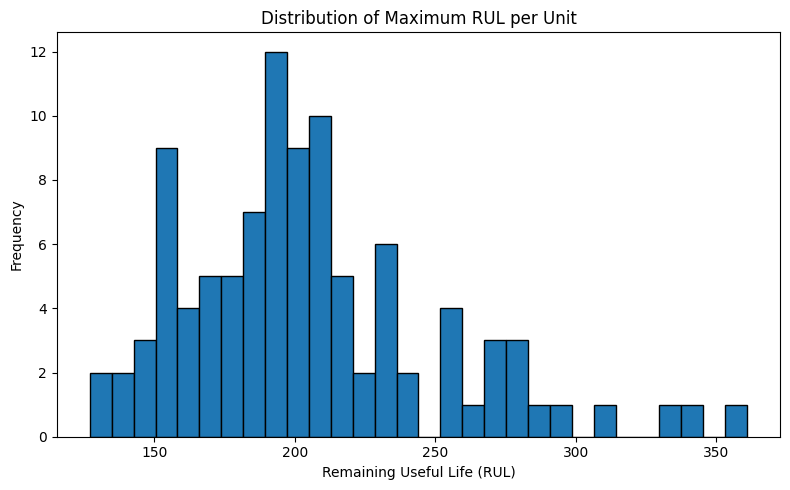

In [11]:
# get the maximum RUL for each unit
df_max_rul = train.groupby('unit_number')['RUL'].max().reset_index()

# plot historgram
plt.figure(figsize=(8, 5))
plt.hist(df_max_rul['RUL'], bins=30, edgecolor='black')

# labels and title
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum RUL per Unit')

plt.tight_layout()
plt.show()


In [12]:
train.head()

unit_number  time_cycles  setting_1  setting_2  setting_3  Temp, fan in  \
0            1            1    -0.0007    -0.0004      100.0        518.67   
1            1            2     0.0019    -0.0003      100.0        518.67   
2            1            3    -0.0043     0.0003      100.0        518.67   
3            1            4     0.0007     0.0000      100.0        518.67   
4            1            5    -0.0019    -0.0002      100.0        518.67   

   Temp, LPC out  Temp, HPC out  Temp, LPT out  Press, fan in  ...  \
0         641.82        1589.70        1400.60          14.62  ...   
1         642.15        1591.82        1403.14          14.62  ...   
2         642.35        1587.99        1404.20          14.62  ...   
3         642.35        1582.79        1401.87          14.62  ...   
4         642.37        1582.85        1406.22          14.62  ...   

   Corr. Speed, Fan  Corr. Speed, Core  Bypass Ratio  Burner Fuel/Air Ratio  \
0           2388.02            8138.62        8.4195                   0.03   
1           2388.07            8131.49        8.4318                   0.03   
2           2388.03            8133.23        8.4178                   0.03   
3           2388.08            8133.83        8.3682                   0.03   
4           2388.04            8133.80        8.4294                   0.03   

   Bleed Enthalpy  Dem Speed, fan  Dem Corr Speed, fan  Coolant Bleed, HPT  \
0             392            2388                100.0               39.06   
1             392            2388                100.0               39.00   
2             390            2388                100.0               38.95   
3             392            2388                100.0               38.88   
4             393            2388                100.0               38.90   

   Coolant Bleed, LPT  RUL  
0             23.4190  191  
1             23.4236  190  
2             23.3442  189  
3             23.3739  188  
4             23.4044  187  

[5 rows x 27 columns]

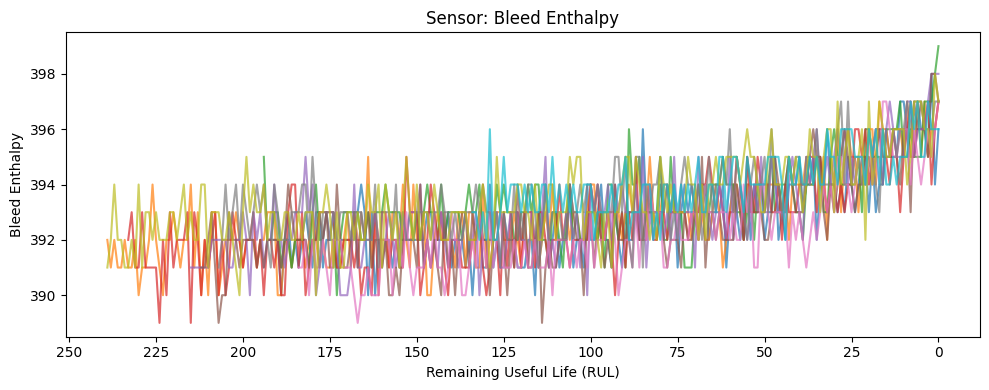

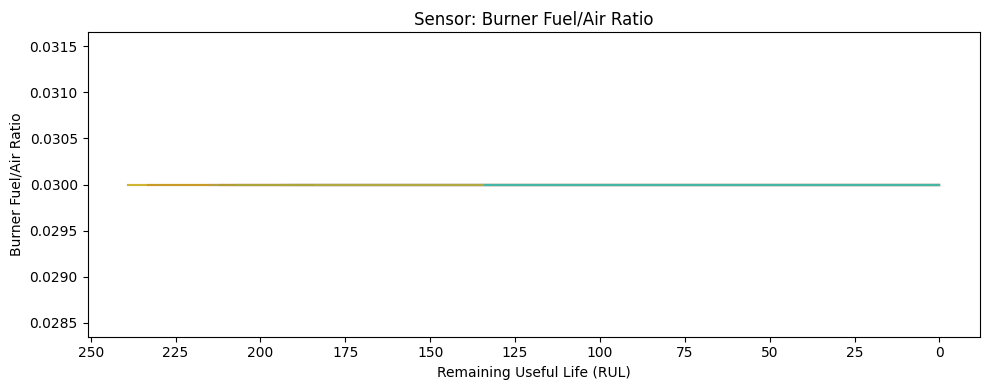

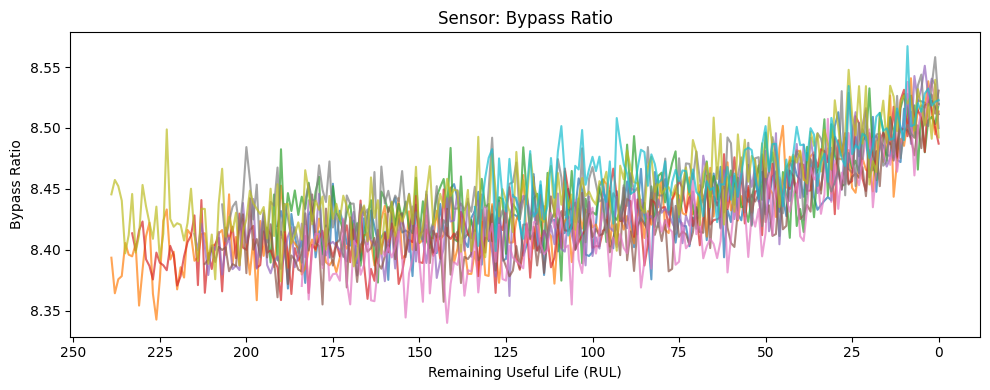

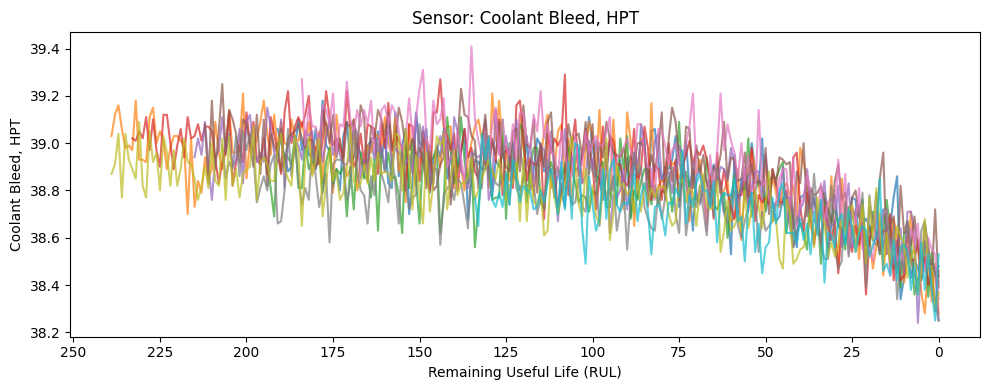

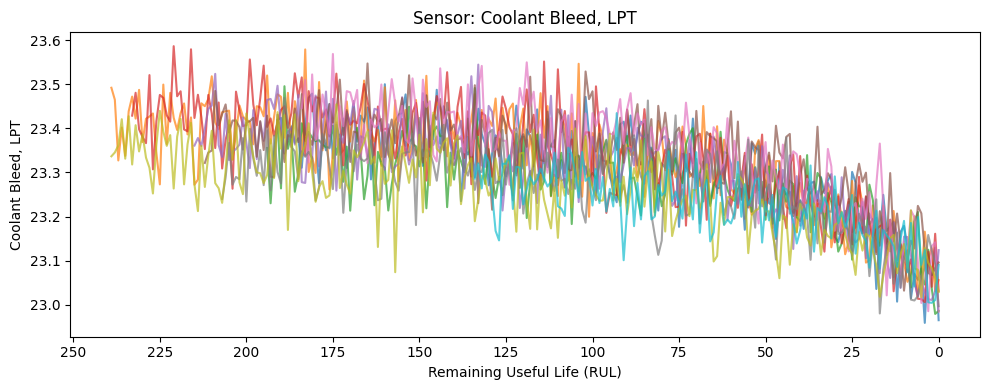

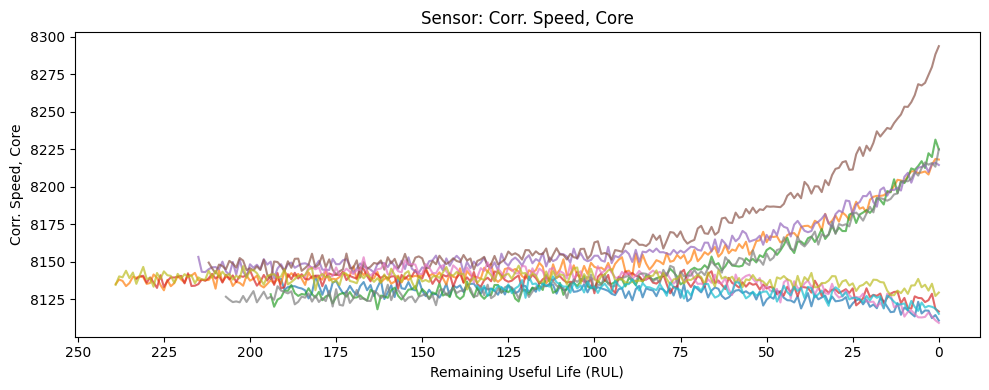

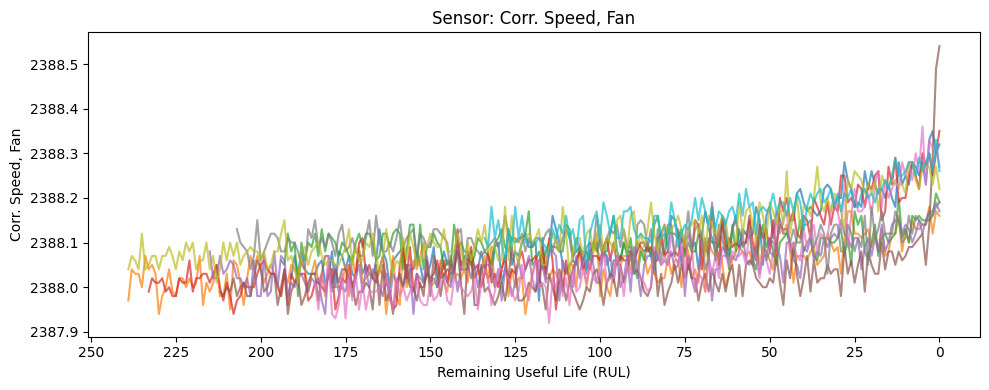

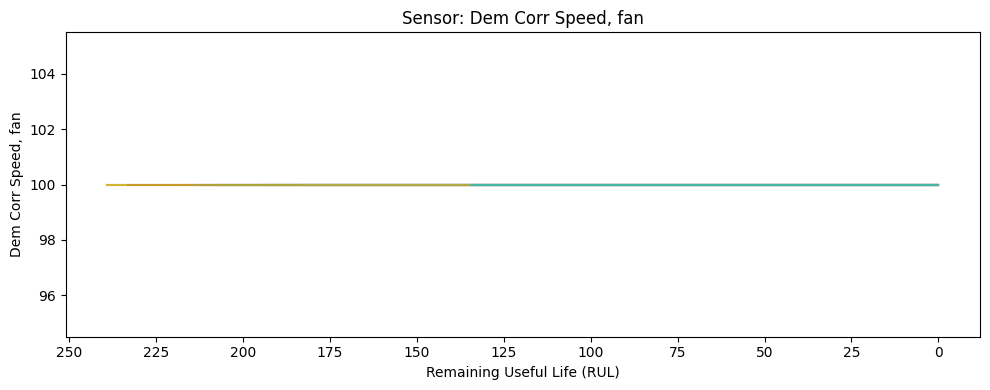

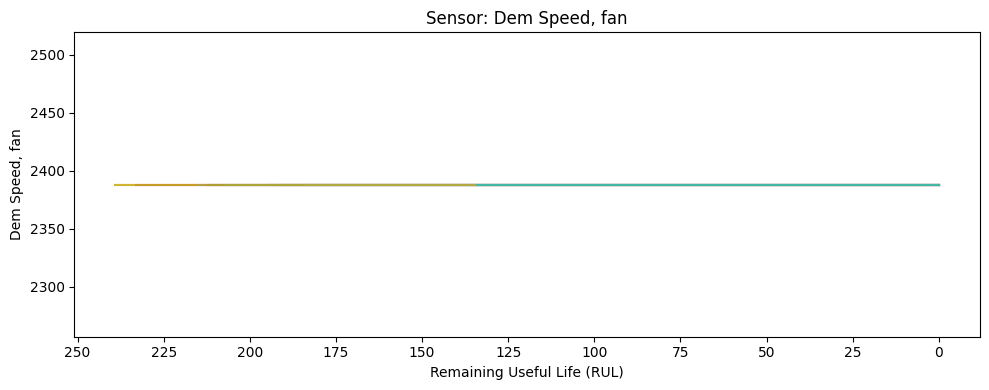

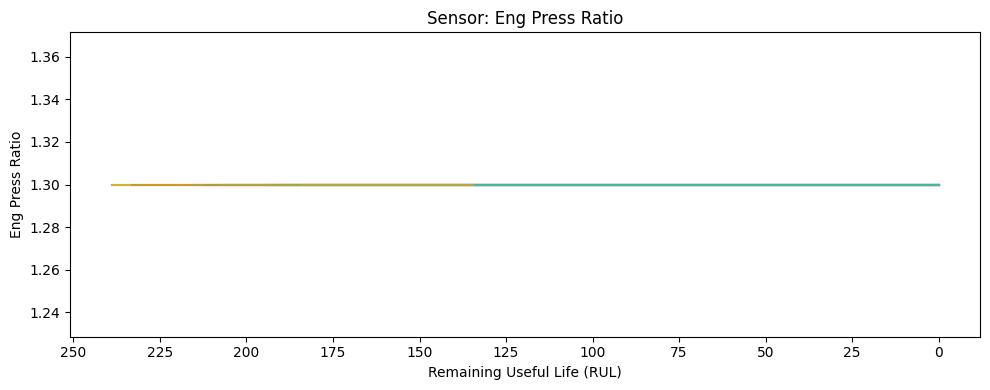

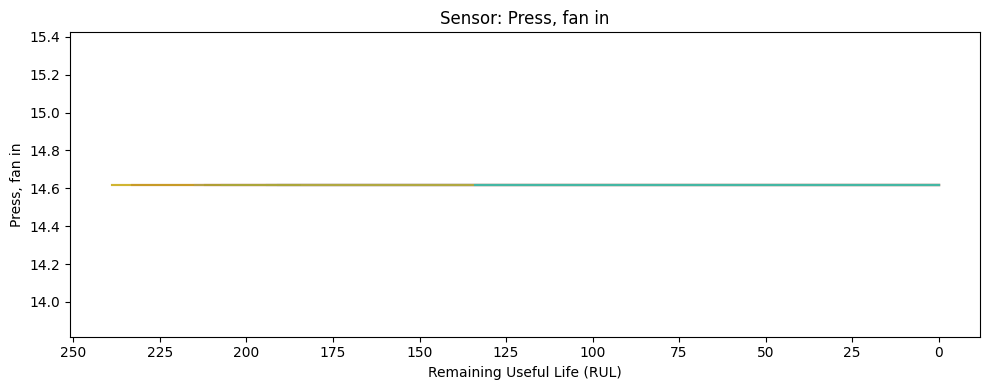

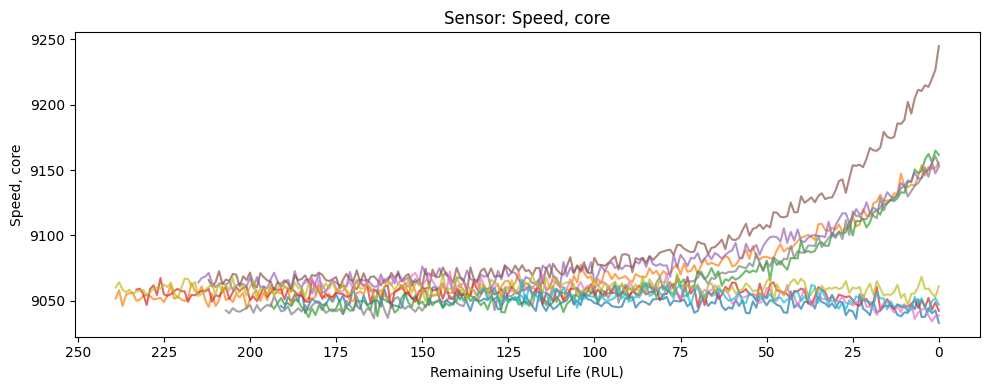

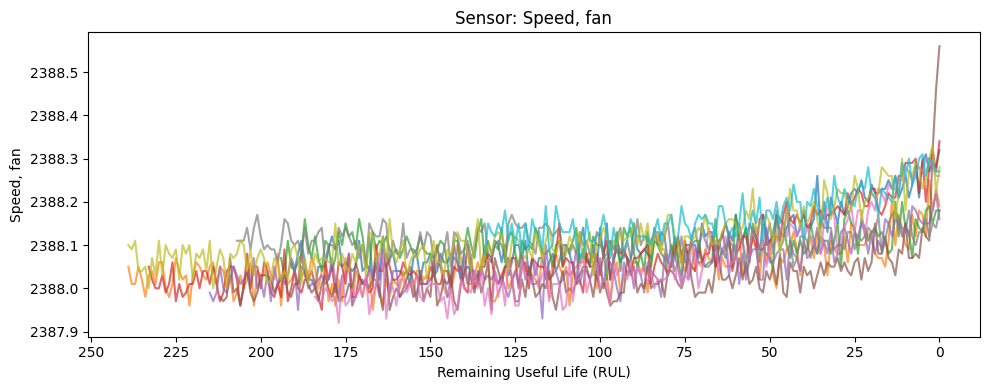

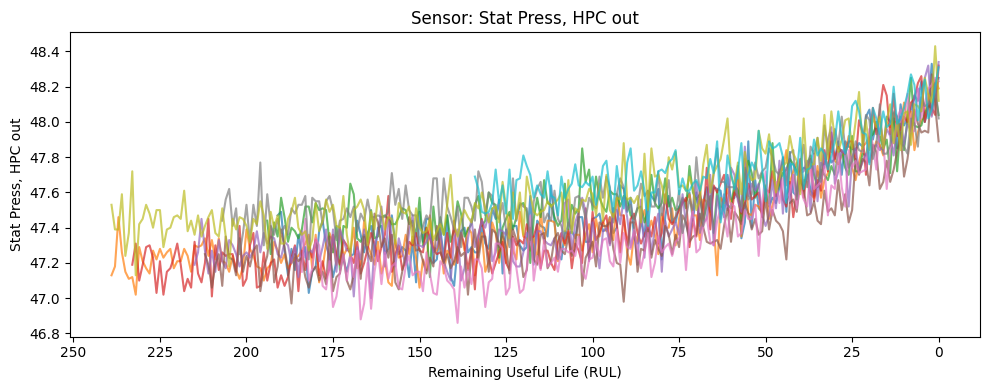

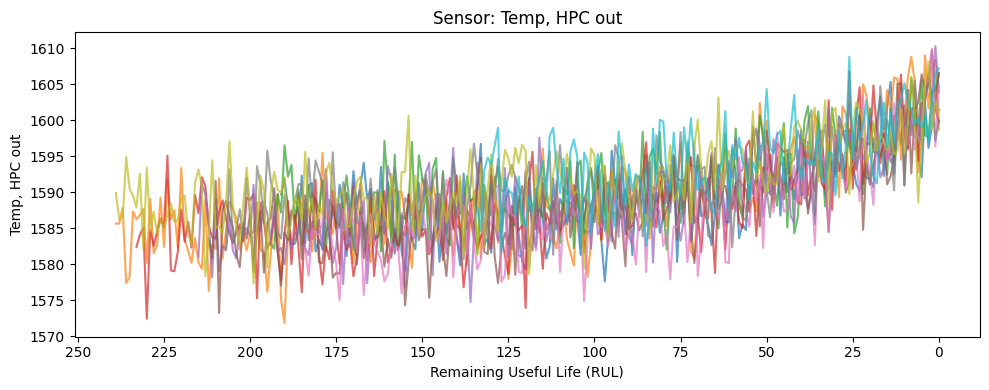

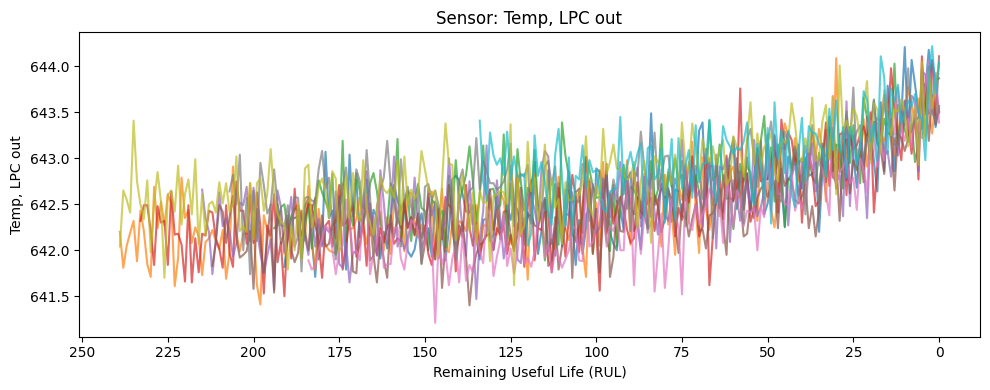

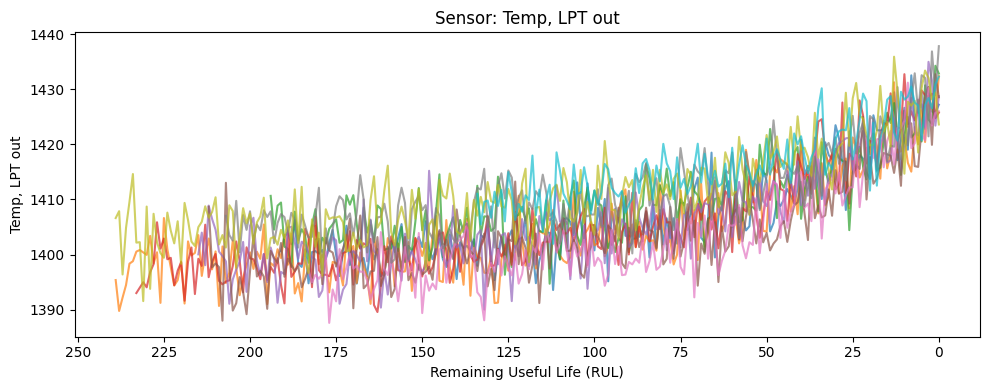

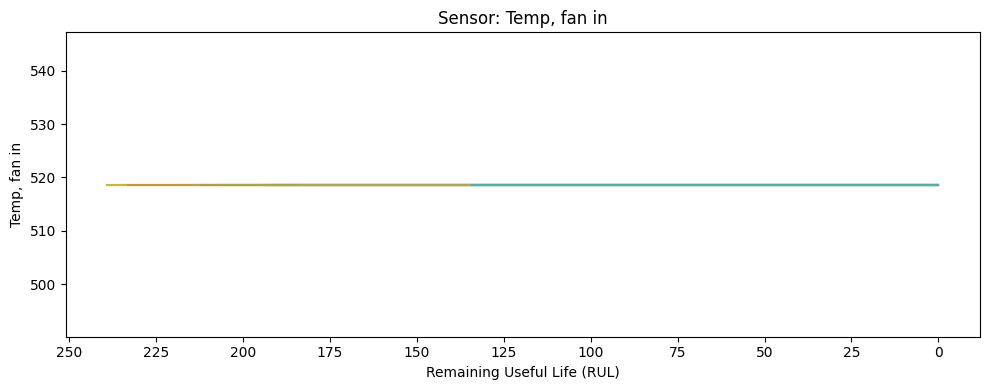

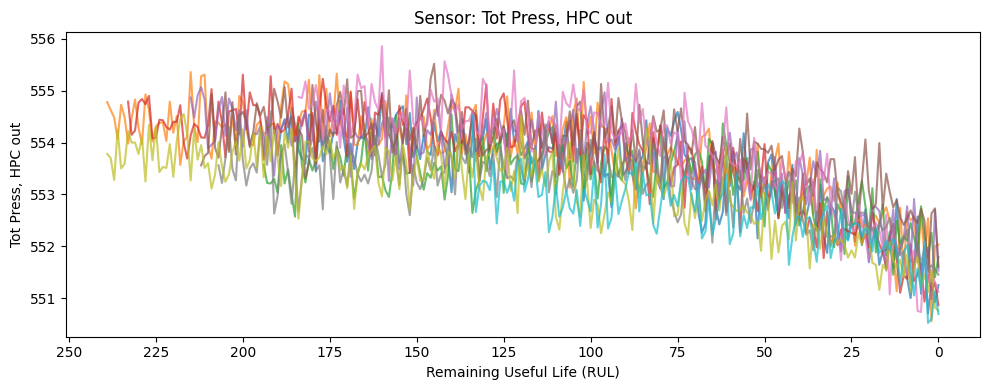

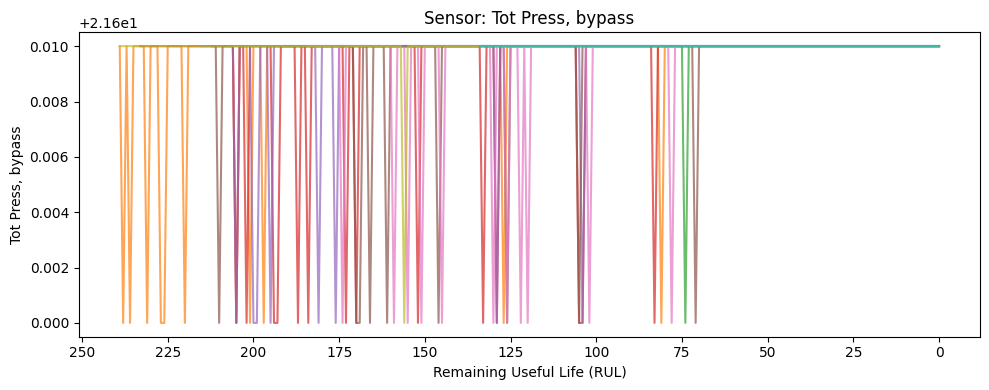

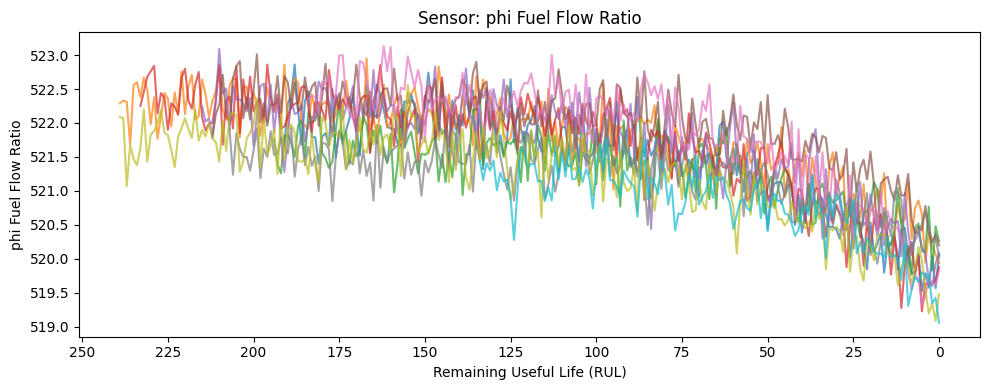

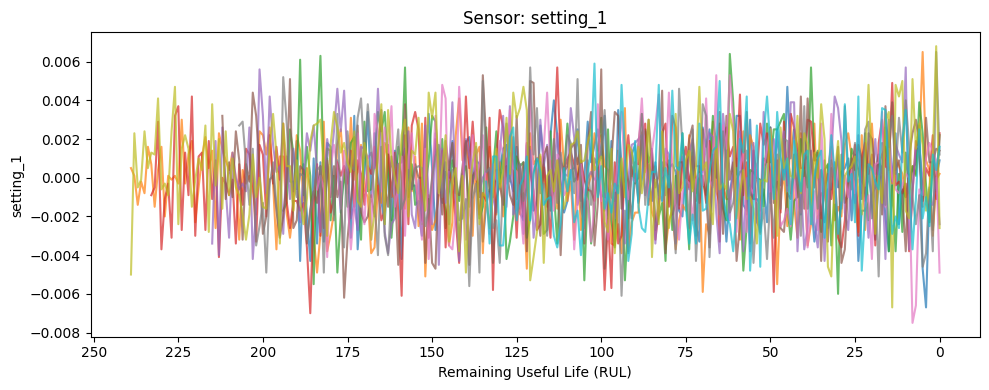

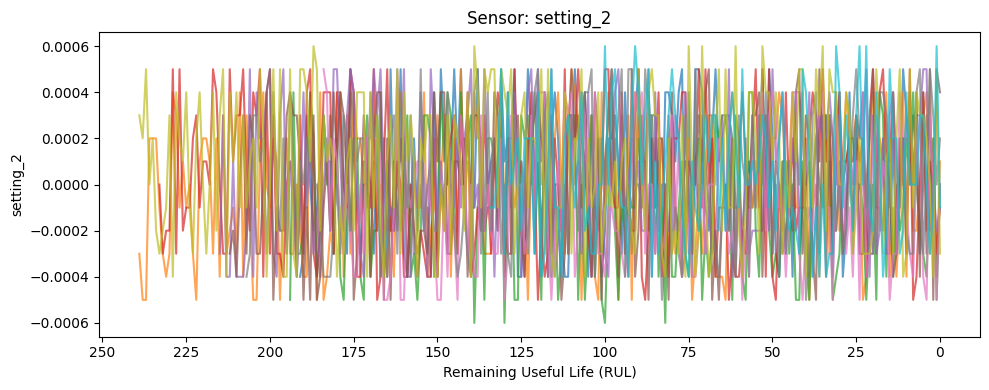

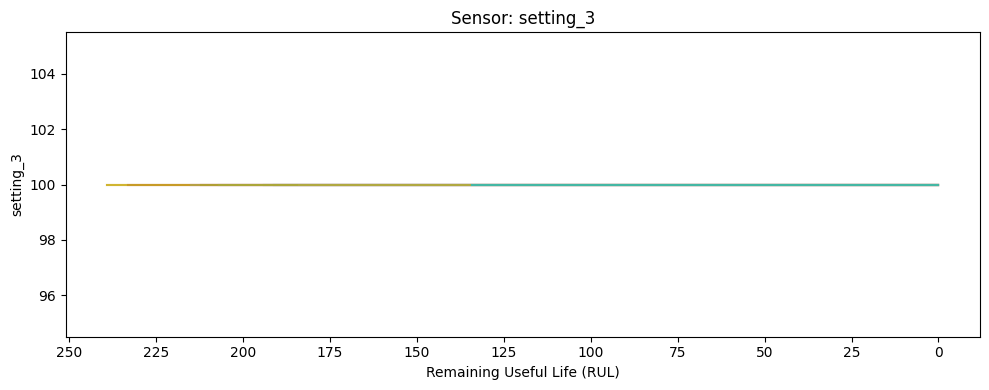

In [13]:
# plot the sensors individually against the RUL
def plot_sensors(train, step=10):

    # find the sensor cols all which have a number in them and excluse unit_number and rul
    sensor_cols = train.columns.difference(['unit_number', 'RUL', 'time_cycles'])

    for sensor in sensor_cols:
        plt.figure(figsize=(10, 4))

        # plot for every nth unit (10th, 20th, 30th ... etc)
        for unit in train['unit_number'].unique()[::step]:
            plt.plot(train[train['unit_number'] == unit]['RUL'],
                     train[train['unit_number'] == unit][sensor],
                     label=f'Unit {unit}', alpha=0.7)

        plt.gca().invert_xaxis()  # reverse the x axis so that RUL is decreasing
        plt.xticks(np.arange(0, 275, 25))
        plt.ylabel(sensor)
        plt.xlabel('Remaining Useful Life (RUL)')
        plt.title(f'Sensor: {sensor}')
        plt.tight_layout()
        plt.show()

# Call the function to plot all sensors
plot_sensors(train)


In [14]:
test.shape

(13096, 26)

In [15]:
test = test[train.columns.intersection(test.columns)]
test.shape

(13096, 26)

In [16]:
train = train.drop('RUL', axis=1)
train.shape

(20631, 26)

## SuperSmoother

Experimenting with smoothers to apply to the df to reduce noise.

In [17]:
from supersmoother import SuperSmoother

def supersmooth(df):
    # create df to store variables 
    smoothed_df = pd.DataFrame()
    smoothed_df['unit_number'] = df['unit_number']
    smoothed_df['time_cycles'] = df['time_cycles']
    
    sensor_cols = df.columns.difference(['unit_number', 'time_cycles'])

    # apply smoother
    for sensor in sensor_cols:
        smoother = SuperSmoother()
        smoother.fit(df['time_cycles'], df[sensor])
        smoothed_df[sensor] = smoother.predict(df['time_cycles'])

    return smoothed_df


# apply to train data
smoothed_df_train = supersmooth(train)
smoothed_df_test = supersmooth(test)

In [19]:
import os

# define the directory path
folder_path = 'SmoothedCMAPSSData'

os.makedirs(folder_path, exist_ok=True)

# save the df to the specified folder
smoothed_df_train.to_csv(os.path.join(folder_path, 'smoothed_train_FD001.txt'), sep=" ", index=False, header=False)
smoothed_df_test.to_csv(os.path.join(folder_path, 'smoothed_test_FD001.txt'), sep=" ", index=False, header=False)